In [1]:
# import the relevant packages and .csv files
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

tdf_riders = pd.read_csv('./raw_data/TDF_Riders_Info.csv')
tdf_riders_history = pd.read_csv('./raw_data/TDF_Riders_History.csv')
all_tdf_stages = pd.read_csv('./raw_data/TDF_Stages_History.csv')
all_riders = pd.read_csv('./raw_data/All_Riders_Info.csv')

Helper functions

In [2]:
def tdf_total_finish_time_column_name(tdf_edition):
    return f'{tdf_edition} TDF Total Finish Time (s)'

def get_tdf_edition_total_distance(tdf_edition_data):
    tdf_edition_total_distance = float(tdf_edition_data.iloc[0]['TotalTDFDistance'])
    return tdf_edition_total_distance

tdf_edition_type_indices_reference = {
    'Individual Time Trial': 1,
    'Team Time Trial': 2,
    'Flat': 3,
    'Hilly': 4,
    'Mountain Time Trial': 5,
    'Mountain': 6
}

def get_tdf_edition_overall_type_index(tdf_edition_data):
    tdf_edition_total_distance = get_tdf_edition_total_distance(tdf_edition_data)
    tdf_edition_overall_type_index = 0

    for tdf_edition_stage_index, tdf_edition_stage_information in tdf_edition_data.iterrows():
        tdf_stage_type = tdf_edition_stage_information['Stage Type']
        tdf_stage_distance = tdf_edition_stage_information['Distance (km)']
        tdf_stage_type_index = tdf_edition_type_indices_reference[tdf_stage_type]
        tdf_edition_overall_type_index += tdf_stage_distance * tdf_stage_type_index

    tdf_edition_overall_type_index /= tdf_edition_total_distance
    return tdf_edition_overall_type_index

Data Cleaning

In [3]:
all_tdf_participated_in = tdf_riders['Tour de Frances participated in']
tdf_editions = []

for tdfs_participated_in in all_tdf_participated_in:
    tdfs_participated_in_list = tdfs_participated_in.split(", ")
    for tdf_edition in tdfs_participated_in_list:
        if int(tdf_edition) not in tdf_editions:
            tdf_editions.append(int(tdf_edition))

tdf_editions.sort()

# all the Tour de France editions that the available riders have raced in (need to get route information for all stages in each of these Tours)
print(f"Tour de Frances: {tdf_editions}")
print(f"Number of Tour de Frances: {len(tdf_editions)}")

Tour de Frances: [1998, 1999, 2000, 2001, 2002, 2004, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Number of Tour de Frances: 24


In [4]:
# create the relevant columns in the dataframe first
for tdf_edition in tdf_editions:
    tdf_riders[tdf_total_finish_time_column_name(tdf_edition)] = ''

# add the total finish times of each Tour de France edition for each rider in the TDF_Riders dataframe
for tdf_edition in tdf_editions:
    for rider_index in range(len(tdf_riders['Rider'])):
        rider = tdf_riders.iloc[rider_index]['Rider']
        tdfs_participated_in_raw = tdf_riders.iloc[rider_index]['Tour de Frances participated in'].split(", ")
        tdfs_participated_in = []
    
        for tdf_edition_raw in tdfs_participated_in_raw:
            tdfs_participated_in.append(int(tdf_edition_raw))

        if tdf_edition not in tdfs_participated_in:
            continue
        else:
            tdf_edition_finishes_dataframe = tdf_riders_history.loc[tdf_riders_history['Year'] == tdf_edition]
            finish_time = tdf_edition_finishes_dataframe.loc[tdf_edition_finishes_dataframe['Rider'] == rider.upper()]['TotalSeconds']
            finish_time = finish_time.to_string().split(" ")[-1]
            tdf_riders.at[rider_index, tdf_total_finish_time_column_name(tdf_edition)] = finish_time

Feature Engineering

In [5]:
tdf_edition_type_indices = {}
tdf_edition_total_distances = {}

# get the Tour de France editions raced by the available riders and the information of each of their stages
tdf_stages_information = all_tdf_stages.loc[all_tdf_stages['Year'].isin(tdf_editions)]

# determine the overall type of each Tour de France edition using weighted average
for tdf_edition in tdf_editions:
    tdf_edition_stages_information = tdf_stages_information.loc[tdf_stages_information['Year'] == tdf_edition]
    tdf_edition_overall_type_index = get_tdf_edition_overall_type_index(tdf_edition_stages_information)
    tdf_edition_total_distance = get_tdf_edition_total_distance(tdf_edition_stages_information)
    tdf_edition_type_indices[tdf_edition] = tdf_edition_overall_type_index
    tdf_edition_total_distances[tdf_edition] = tdf_edition_total_distance

# the overall type of Tour de France each edition is. the higher the index, the more mountainous it is
print(tdf_edition_type_indices)

print(tdf_edition_total_distances)

{1998: 3.721961290322581, 1999: 3.756515849363316, 2000: 3.8398416166029494, 2001: 3.5834875650665126, 2002: 3.859060402684564, 2004: 3.8003833677381302, 2006: 3.8958435876401425, 2007: 4.040588235294117, 2008: 3.9402922169148638, 2009: 4.1096820809248555, 2010: 4.057084019769357, 2011: 3.8028925619834713, 2012: 3.912467829568201, 2013: 4.223266745005875, 2014: 4.0663295982508885, 2015: 4.255158020274299, 2016: 4.162269503546099, 2017: 4.123446327683616, 2018: 4.074350552403702, 2019: 4.224866310160428, 2020: 4.407694516221648, 2021: 4.629884717706179, 2022: 4.5211538461538465, 2023: 4.427849588719154}
{1998: 3875.0, 1999: 3691.0, 2000: 3662.0, 2001: 3458.0, 2002: 3278.0, 2004: 3391.0, 2006: 3657.0, 2007: 3570.0, 2008: 3559.0, 2009: 3460.0, 2010: 3642.0, 2011: 3630.0, 2012: 3497.0, 2013: 3404.0, 2014: 3659.0, 2015: 3354.0, 2016: 3525.0, 2017: 3540.0, 2018: 3349.0, 2019: 3366.0, 2020: 3483.0, 2021: 3383.0, 2022: 3328.0, 2023: 3404.0}


In [6]:
time_trial = 'Points (Time Trial)'
sprint = 'Points (Sprint)'
gc = 'Points (GC)'
climb = 'Points (Climb)'
rider_type = 'Rider Type Index'
rider_type_indices_reference = {
    time_trial: 1,
    sprint: 2,
    gc: 3,
    climb: 4
}
rider_type_indices = {}
tdf_rider_type_indices = {}

# calculate the overall type of all available riders
tdf_riders_list = tdf_riders['Rider'].to_list()

for rider_index, rider_information in all_riders.iterrows():
    rider_name = rider_information['Rider']
    rider_time_trial_points = rider_information[time_trial]
    rider_sprint_points = rider_information[sprint]
    rider_gc_points = rider_information[gc]
    rider_climb_points = rider_information[climb]
    rider_total_points = rider_time_trial_points + rider_sprint_points + rider_gc_points + rider_climb_points
    rider_overall_type_index = ((rider_type_indices_reference[time_trial] * rider_time_trial_points) + (rider_type_indices_reference[sprint] * rider_sprint_points) + (rider_type_indices_reference[gc] * rider_gc_points) + (rider_type_indices_reference[climb] * rider_climb_points))/rider_total_points
    rider_type_indices[rider_name] = rider_overall_type_index
    all_riders.at[rider_index, rider_type] = rider_overall_type_index

# calculate the overall type of riders who have raced in the Tour de France before
for tdf_rider_index, tdf_rider_information in tdf_riders.iterrows():
    tdf_rider_name = tdf_rider_information['Rider']
    tdf_rider_time_trial_points = tdf_rider_information[time_trial]
    tdf_rider_sprint_points = tdf_rider_information[sprint]
    tdf_rider_gc_points = tdf_rider_information[gc]
    tdf_rider_climb_points = tdf_rider_information[climb]
    tdf_rider_total_points = tdf_rider_time_trial_points + tdf_rider_sprint_points + tdf_rider_gc_points + tdf_rider_climb_points
    tdf_rider_overall_type_index = ((rider_type_indices_reference[time_trial] * tdf_rider_time_trial_points) + (rider_type_indices_reference[sprint] * tdf_rider_sprint_points) + (rider_type_indices_reference[gc] * tdf_rider_gc_points) + (rider_type_indices_reference[climb] * tdf_rider_climb_points))/tdf_rider_total_points
    tdf_rider_type_indices[tdf_rider_name] = tdf_rider_overall_type_index
    tdf_riders.at[tdf_rider_index, rider_type] = tdf_rider_overall_type_index

# the overall type of each rider. the higher the index, the better the rider is at mountainous stages. the lower the index, the better the rider is at time trial and flat stages
print(rider_type_indices)
all_riders.to_csv('./cleaned_data/All_Riders_Info_With_Type.csv', sep=',', encoding='utf-8', index=False)
tdf_riders.to_csv('./cleaned_data/TDF_Riders_With_Timing_Type.csv', sep=',', encoding='utf-8', index=False)

{'Adam de Vos': 2.5163398692810457, 'Alessandro De Marchi': 3.2452179366572595, 'Alex Dowsett': 1.4525337464040717, 'Alexander Kristoff': 2.6132397449932383, 'Angel Madrazo': 3.17968291250734, 'Ben King': 2.8899755501222493, 'Ben O’Connor': 3.3228920409771474, 'Ben Swift': 2.7648148148148146, 'Boris Vallee': 2.1479524438573314, 'Bradley Wiggins': 2.1244852708267343, 'Bruno Armirail': 2.015135135135135, 'Chris Hamilton': 3.3459037711313395, 'Clement Venturini': 2.9164685908319186, 'Connor Dunne': 2.299595141700405, 'Connor Swift': 2.712750716332378, 'Damien Touze': 2.897828863346105, 'Daniel Oss': 2.617008069522036, 'Dimitri Claeys': 2.4968274111675126, 'Dion Smith': 3.1022408963585435, 'Dorian Godon': 3.368738684369342, 'Dylan Sunderland': 3.071844660194175, 'Egan Bernal': 3.3345445736434107, 'Emils Liepins': 2.1463536463536466, 'Florian Vermeersch': 2.419667590027701, 'Frederik Backaert': 2.623853211009174, 'Gabriel Cullaigh': 2.1733021077283374, 'Geoffrey Soupe': 2.5316363636363635, 

Features (independent variable) preparation

In [7]:
# rider features
ftp = 'FTP (w)'
weight = 'Weight (kg)'
power_to_weight_ratio = 'Power-to-Weight Ratio (w/kg)'
height = 'Height (m)'
tdfs_participated_in_label = 'Tour de Frances participated in' # to indicate which Tour de France edition to use when training the regression model
name = 'Rider' # to indicate which Tour de France total finish timing to use when training the regression model
features_riders = tdf_riders[[name, ftp, weight, power_to_weight_ratio, height, rider_type, tdfs_participated_in_label]].copy()

# Tour de France edition features
total_distance = 'Total Distance (km)'
edition_type = 'Edition Type Index'
year = 'Edition Year' # to indicate which rider to use the Tour de France edition features on

features_list = []

for feature_rider_index, feature_rider_information in features_riders.iterrows():
    tdfs_participated_in_raw = feature_rider_information['Tour de Frances participated in'].split(", ")
    tdfs_participated_in = []

    for tdf_edition_raw in tdfs_participated_in_raw:
        tdfs_participated_in.append(int(tdf_edition_raw))

    for tdf_participated_in in tdfs_participated_in:
        features_list.append([
            feature_rider_information[ftp],
            feature_rider_information[weight],
            feature_rider_information[power_to_weight_ratio],
            feature_rider_information[height],
            feature_rider_information[rider_type],
            tdf_edition_total_distances[tdf_participated_in],
            tdf_edition_type_indices[tdf_participated_in]
        ])

features = pd.DataFrame(features_list, columns=[ftp, weight, power_to_weight_ratio, height, rider_type, total_distance, edition_type])
display(features)

,FTP (w),Weight (kg),Power-to-Weight Ratio (w/kg),Height (m),Rider Type Index,Total Distance (km),Edition Type Index
0,399,66,6.05,1.81,3.245218,3483.0,4.407695
1,399,66,6.05,1.81,3.245218,3540.0,4.123446
2,399,66,6.05,1.81,3.245218,3659.0,4.066330
3,399,66,6.05,1.81,3.245218,3404.0,4.223267
4,400,79,5.06,1.82,1.452534,3366.0,4.224866
...,...,...,...,...,...,...,...
194,371,72,5.15,1.82,2.371918,3483.0,4.407695
195,394,69,5.71,1.73,1.836191,3404.0,4.427850
196,460,78,5.90,1.90,2.693224,3328.0,4.521154
197,460,78,5.90,1.90,2.693224,3383.0,4.629885


Target (dependent variable) preparation

In [8]:
#target
finish_time = 'TDF Total Finish Time (s)'

target_list = []

for tdf_rider_index, tdf_rider_information in tdf_riders.iterrows():
    tdfs_participated_in_raw = tdf_rider_information.loc[tdfs_participated_in_label].split(", ")
    tdfs_participated_in = []

    for tdf_edition_raw in tdfs_participated_in_raw:
        tdfs_participated_in.append(int(tdf_edition_raw))

    for tdf_participated_in in tdfs_participated_in:
        target_list.append(tdf_rider_information[tdf_total_finish_time_column_name(tdf_participated_in)])

target = pd.DataFrame(target_list, columns=[finish_time])
print(target)

    TDF Total Finish Time (s)
0                      330851
1                      322100
2                      333240
3                      310791
4                      313899
..                        ...
194                    330802
195                    308440
196                    292155
197                    302018
198                    319236

[199 rows x 1 columns]


Visualising the available data (features and targets)

In [9]:
dataset = pd.merge(features, target, left_index=True, right_index=True)
dataset = dataset.astype(float)
display(dataset)

,FTP (w),Weight (kg),Power-to-Weight Ratio (w/kg),Height (m),Rider Type Index,Total Distance (km),Edition Type Index,TDF Total Finish Time (s)
0,399.0,66.0,6.05,1.81,3.245218,3483.0,4.407695,330851.0
1,399.0,66.0,6.05,1.81,3.245218,3540.0,4.123446,322100.0
2,399.0,66.0,6.05,1.81,3.245218,3659.0,4.066330,333240.0
3,399.0,66.0,6.05,1.81,3.245218,3404.0,4.223267,310791.0
4,400.0,79.0,5.06,1.82,1.452534,3366.0,4.224866,313899.0
...,...,...,...,...,...,...,...,...
194,371.0,72.0,5.15,1.82,2.371918,3483.0,4.407695,330802.0
195,394.0,69.0,5.71,1.73,1.836191,3404.0,4.427850,308440.0
196,460.0,78.0,5.90,1.90,2.693224,3328.0,4.521154,292155.0
197,460.0,78.0,5.90,1.90,2.693224,3383.0,4.629885,302018.0


<Axes: >

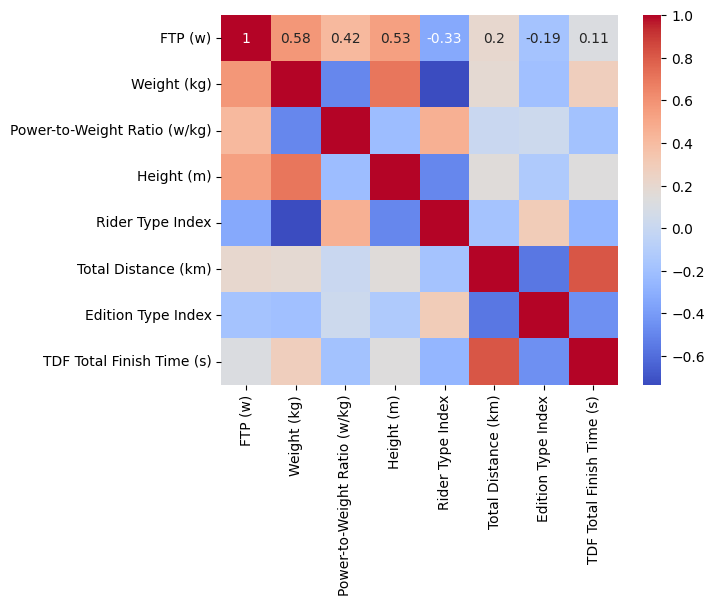

In [10]:

matrix = dataset.corr(method='pearson')
sns.heatmap(matrix, annot=True, cmap='coolwarm')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

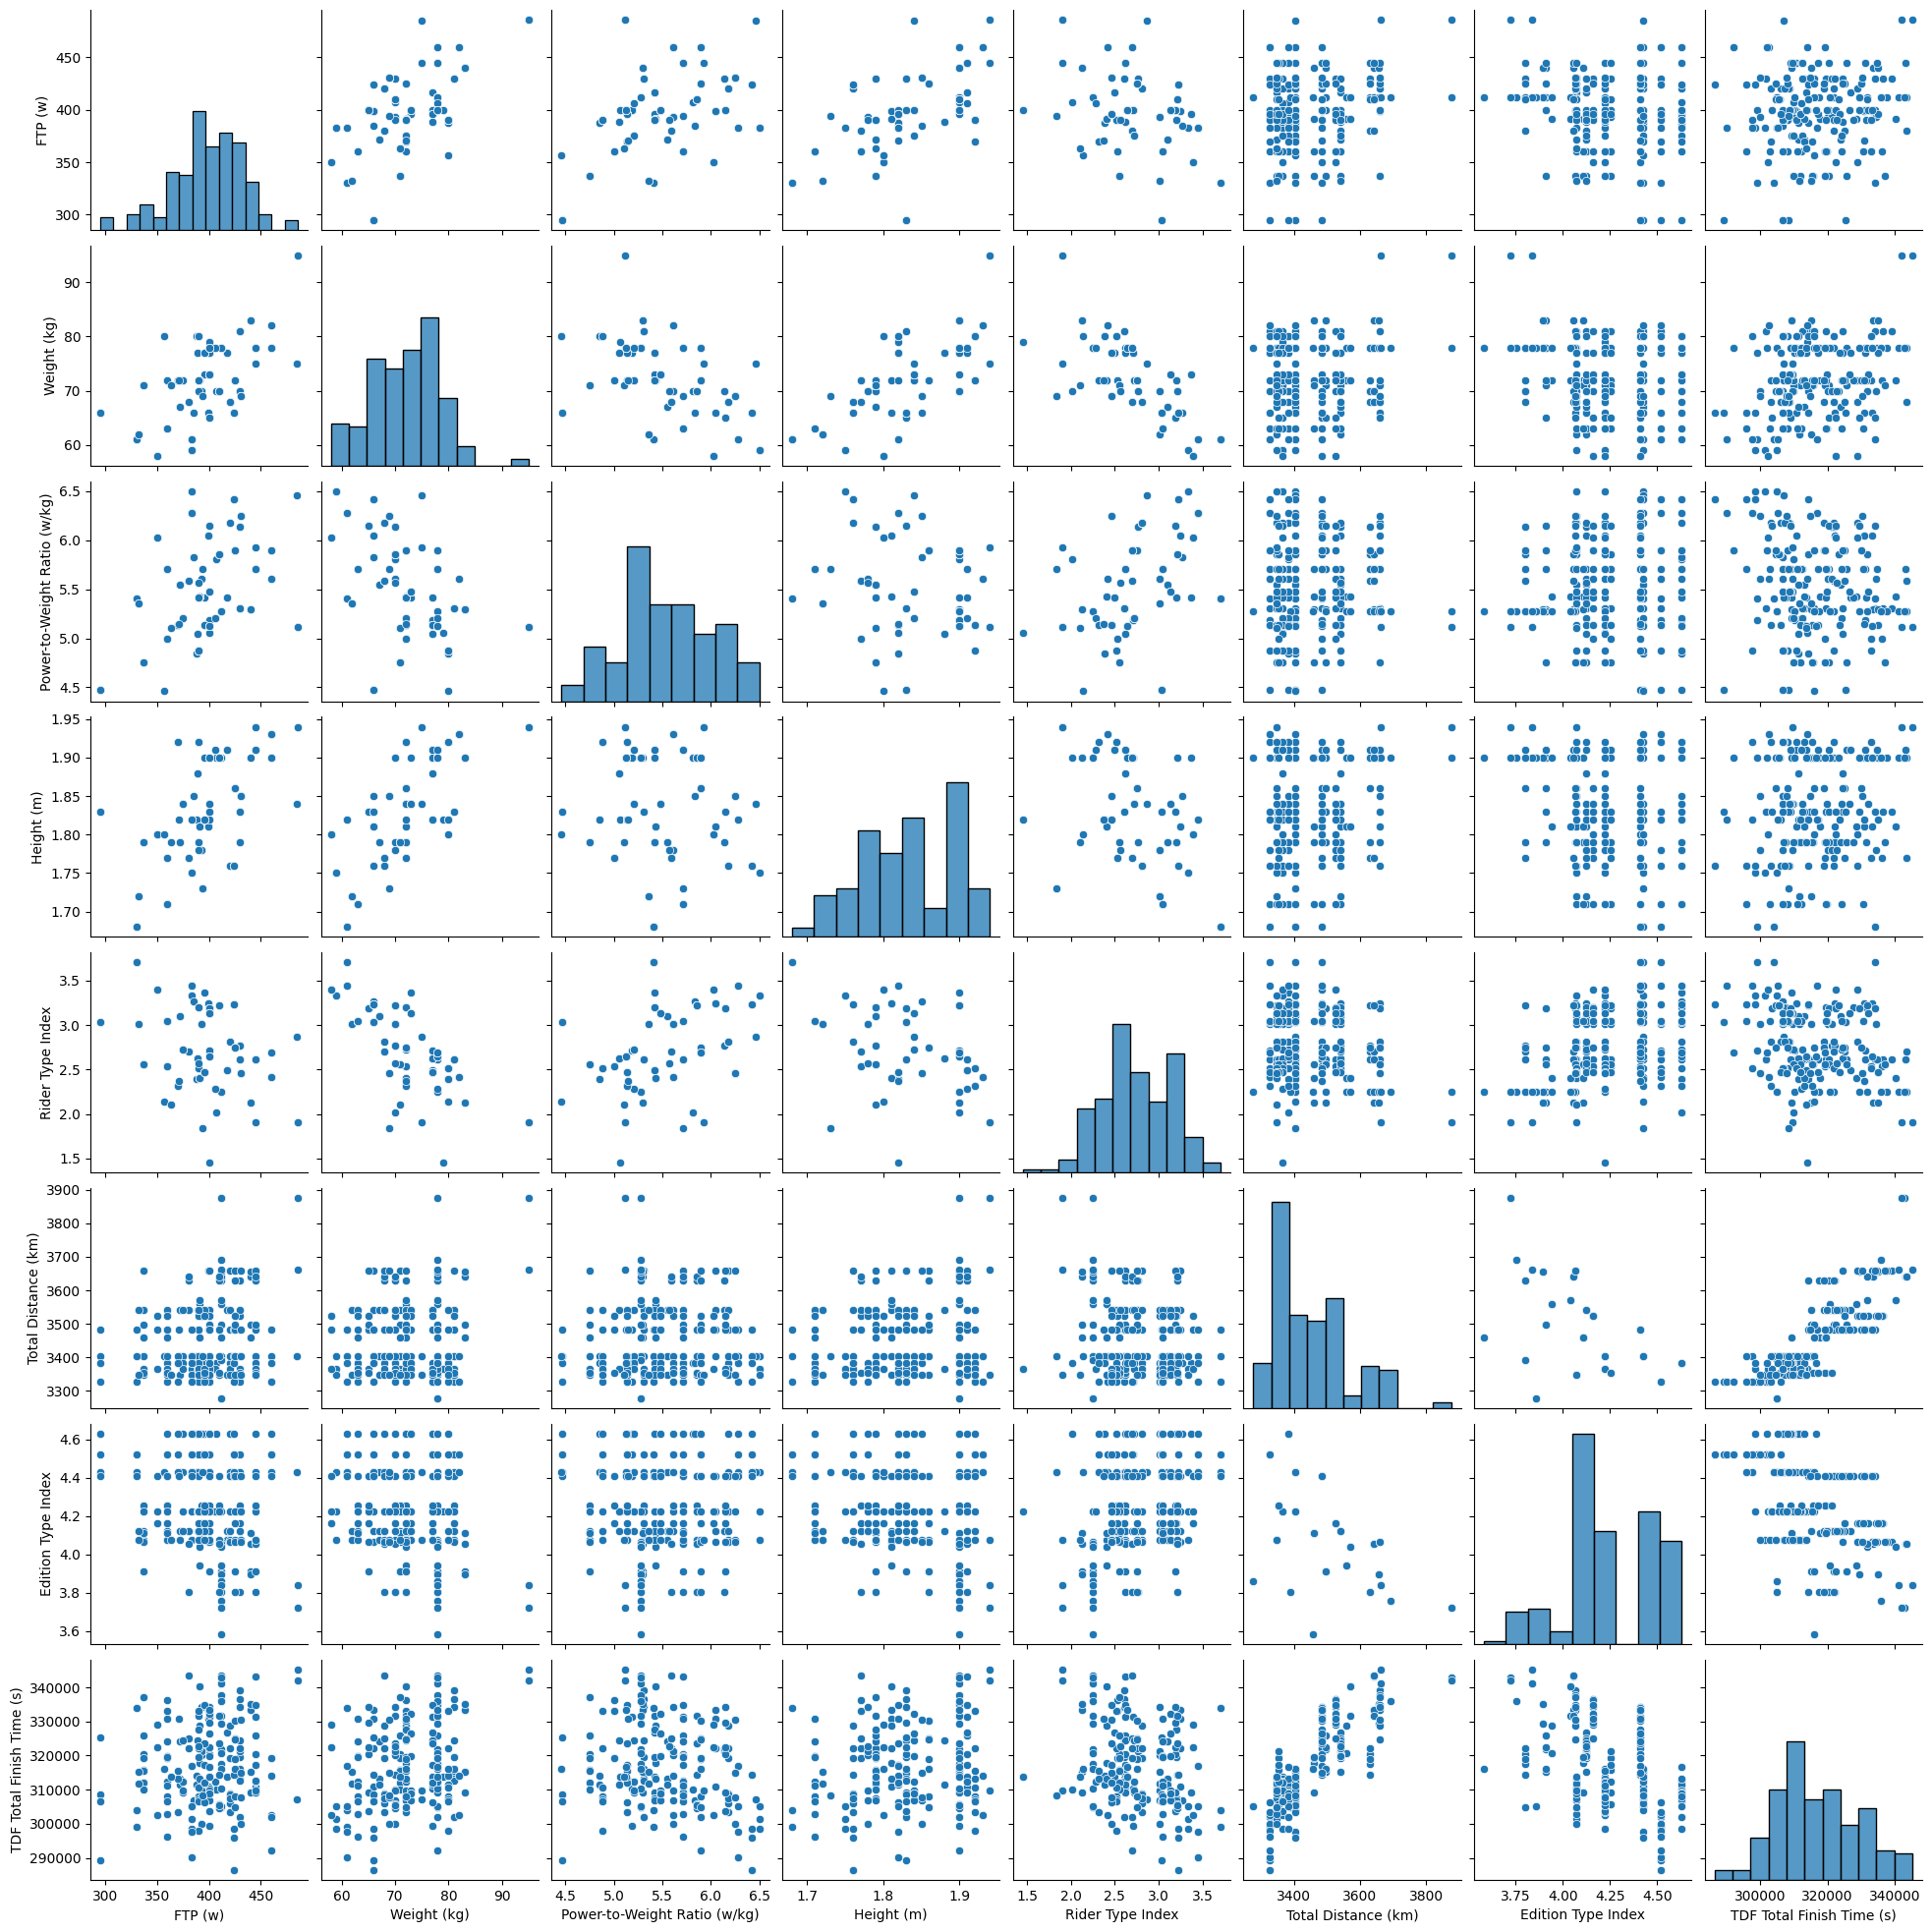

In [11]:
sns.pairplot(data=dataset)

In [12]:
display(dataset.describe())

,FTP (w),Weight (kg),Power-to-Weight Ratio (w/kg),Height (m),Rider Type Index,Total Distance (km),Edition Type Index,TDF Total Finish Time (s)
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,397.904523,72.246231,5.529347,1.832362,2.753426,3455.753769,4.234759,316857.939698
std,34.922655,6.658683,0.469545,0.063897,0.399059,110.560485,0.232326,12054.618825
min,295.000000,58.000000,4.460000,1.680000,1.452534,3278.000000,3.583488,286563.000000
25%,383.000000,68.000000,5.210000,1.790000,2.496827,3366.000000,4.074351,308288.500000
50%,400.000000,72.000000,5.480000,1.830000,2.697657,3404.000000,4.223267,314973.000000
75%,422.000000,78.000000,5.880000,1.900000,3.102241,3525.000000,4.427850,324807.000000
max,486.000000,95.000000,6.500000,1.940000,3.703470,3875.000000,4.629885,345215.000000


Regression model training and evaluations 

In [32]:
dataset_sm = dataset.copy()
dataset_sm.columns = [
    'ftp',
    'weight',
    'power_to_weight_ratio',
    'height',
    'rider_type_index',
    'total_distance',
    'edition_type_index',
    'tdf_total_finish_time'
]
model_sm = ols('tdf_total_finish_time ~ ftp + weight + power_to_weight_ratio + height + rider_type_index + total_distance + edition_type_index', data=dataset_sm).fit()
results_sm = model_sm.summary()
print(results_sm)
anova_sm = sm.stats.anova_lm(model_sm, typ=2)
print("---------------------------------------------------------------------------------------------------")
print("ANOVA")
print("---------------------------------------------------------------------------------------------------")
print(anova_sm)

                              OLS Regression Results                             
Dep. Variable:     tdf_total_finish_time   R-squared:                       0.713
Model:                               OLS   Adj. R-squared:                  0.703
Method:                    Least Squares   F-statistic:                     67.94
Date:                   Thu, 28 Sep 2023   Prob (F-statistic):           1.76e-48
Time:                           23:51:42   Log-Likelihood:                -2027.5
No. Observations:                    199   AIC:                             4071.
Df Residuals:                        191   BIC:                             4097.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


Model evaluation

In [33]:
# export the dataset to Excel to perform regression analysis
dataset.to_csv('./cleaned_data/Dataset.csv', sep=',', encoding='utf-8', index=False)